<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [1]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [2]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [3]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [4]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



In [5]:
print('Fecha Inicio: {}\nFecha Fin:    {}'.format(df.date.min(),df.date.max()))
# formato datetime de las fechas
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# dejar en formato ts
y=df.set_index('date')['pdq'].resample('ME').mean()

y.head()

Fecha Inicio: 2015-01-01 00:00:00
Fecha Fin:    2021-11-26 00:00:00


,pdq
date,
2015-01-31,26.258786
2015-02-28,25.441553
2015-03-31,26.839359
2015-04-30,26.415530
2015-05-31,26.240645


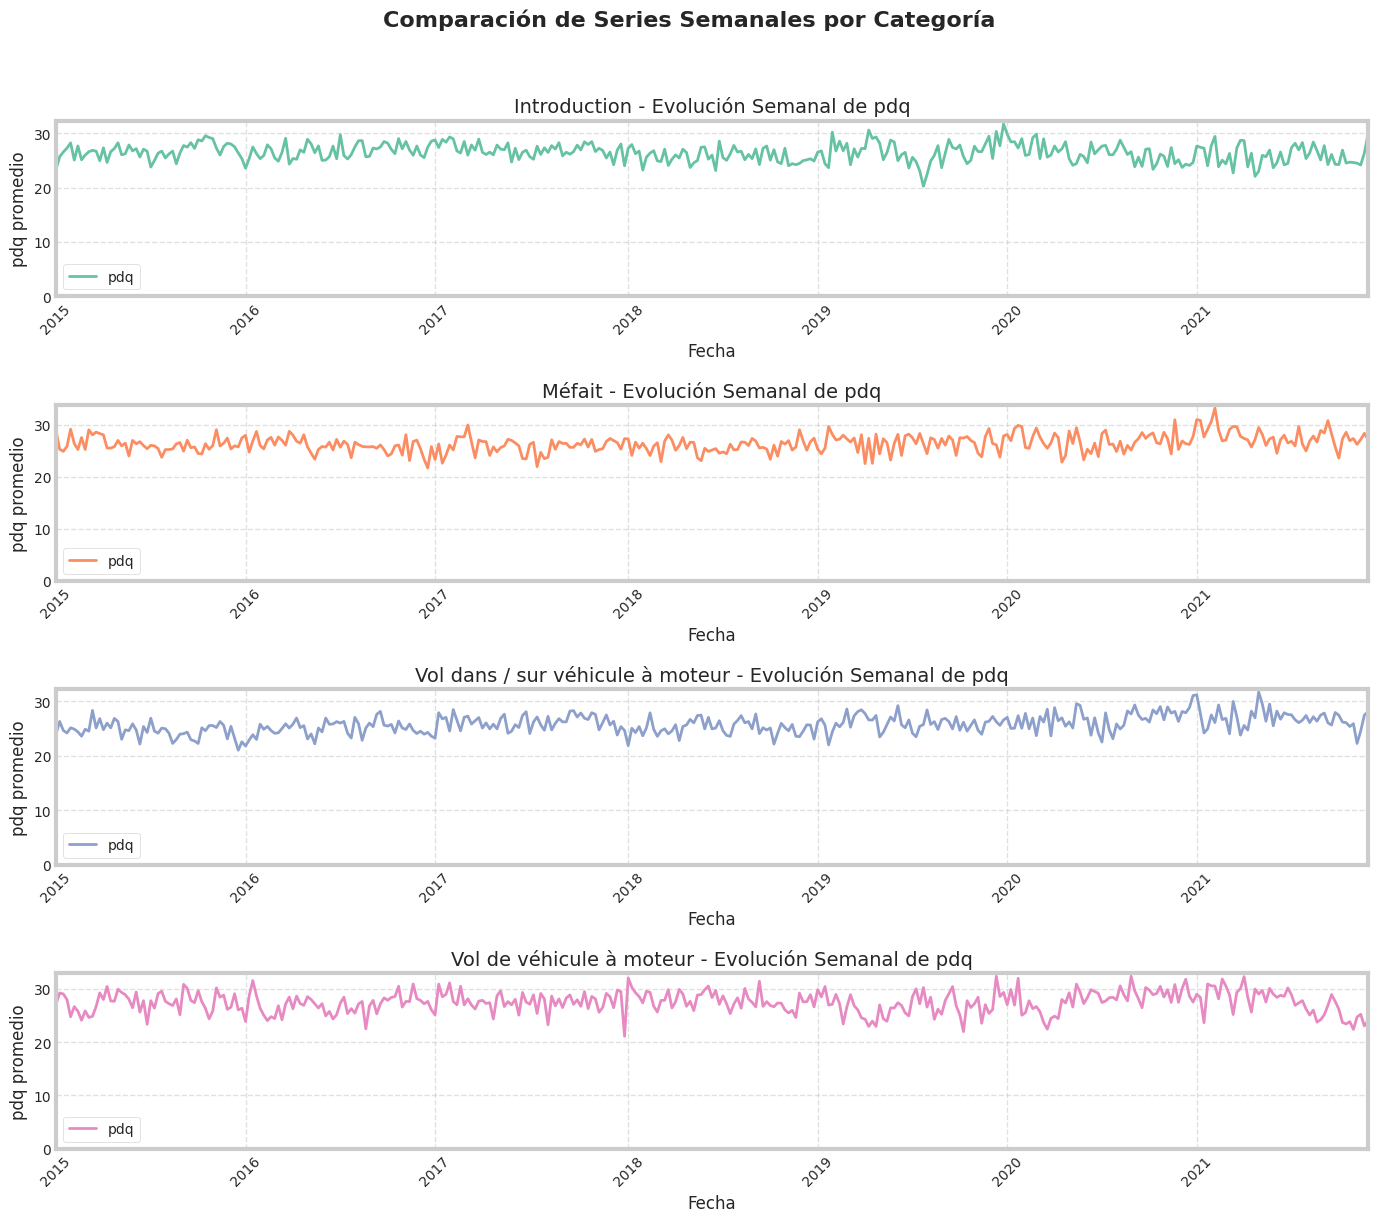

In [6]:
# Visualizacion
sns.set_style("whitegrid")
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
colors = sns.color_palette("Set2", 4)

y_s1.plot(ax=axes[0], color=colors[0], linewidth=2)
axes[0].set_title(f"{validate_categorie[0]} - Evolución Semanal de pdq")
axes[0].set_ylabel("pdq promedio")

y_s2.plot(ax=axes[1], color=colors[1], linewidth=2)
axes[1].set_title(f"{validate_categorie[1]} - Evolución Semanal de pdq")
axes[1].set_ylabel("pdq promedio")

y_s3.plot(ax=axes[2], color=colors[2], linewidth=2)
axes[2].set_title(f"{validate_categorie[2]} - Evolución Semanal de pdq")
axes[2].set_ylabel("pdq promedio")

y_s4.plot(ax=axes[3], color=colors[3], linewidth=2)
axes[3].set_title(f"{validate_categorie[3]} - Evolución Semanal de pdq")
axes[3].set_ylabel("pdq promedio")

# Ejes y formato general
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel("Fecha")
    ax.set_ylim(bottom=0)  # si tus valores son positivos, mejora la escala
    ax.tick_params(axis='x', rotation=45)

# Título general
fig.suptitle("Comparación de Series Semanales por Categoría", fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



#1. Analisis exploratorio


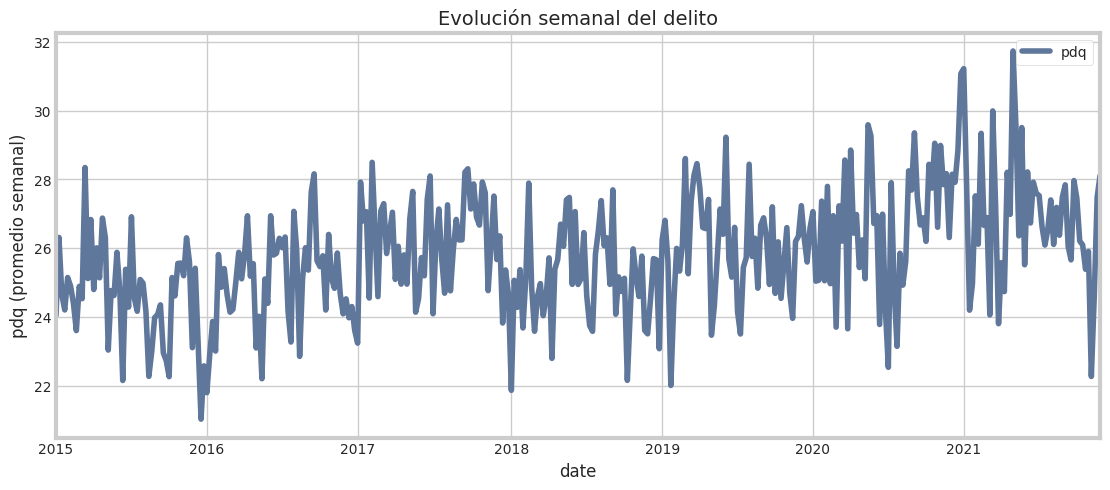

In [7]:
y = y_s3[['pdq']].copy()
y.plot(figsize=(12, 5), title='Evolución semanal del delito', ylabel='pdq (promedio semanal)')
plt.show()


Entre 2015 y 2018 los valores son estables pero desde 2019 hay mayor movimiento y picos más marcados, con un maximo hacia 2021. Lo que implicaria que hay una tendencia al alza con los años, en particular desde 2019, que podria estra relacionado con el contexto social del momento (pandemia)


/tmp/ipython-input-2000088111.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='pdq', data=y, palette='coolwarm')


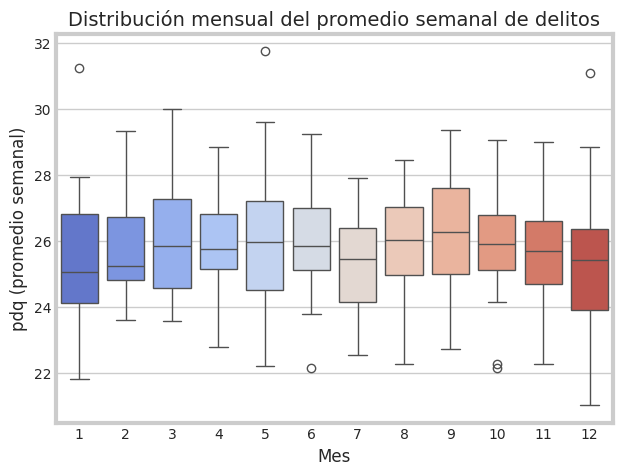

In [8]:
y['month'] = y.index.month
sns.boxplot(x='month', y='pdq', data=y, palette='coolwarm')
plt.title('Distribución mensual del promedio semanal de delitos')
plt.xlabel('Mes')
plt.ylabel('pdq (promedio semanal)')
plt.show()

Los meses de julio a octubre tienden a tener valores ligeramente más altos mientras que enero a marzo muestran valores más bajos y sin outliers (existe una baja variabilidad), por ende se tiene una una estacionalidad moderada.

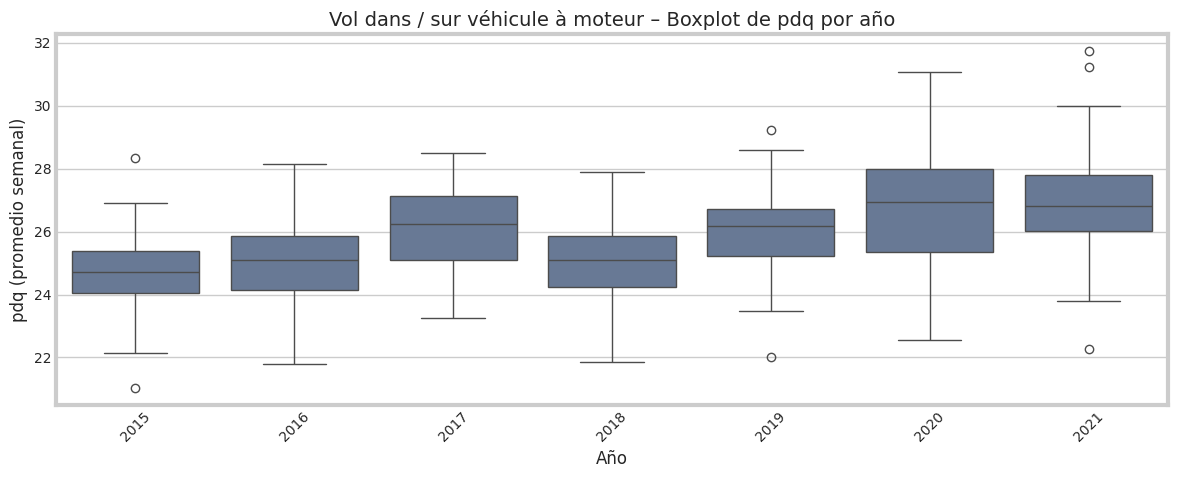

In [9]:
y = y.asfreq('W')
y['pdq'] = y['pdq'].interpolate()

y['year'] = y.index.year

fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=y, x='year', y='pdq', ax=ax)

ax.set_title(f"{validate_categorie[2]} – Boxplot de pdq por año")
ax.set_xlabel("Año")
ax.set_ylabel("pdq (promedio semanal)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


2015 a 2018 se mantienen con valores más bajos y estables. Y desde 2019 y 2020 presentan medianas altas y mas variabilidad. con esto tenemos que existe un incremento progresivo en la frecuencia semanal promedio de robos de vehículos hasta 2020, seguido de una leve estabilización en 2021.

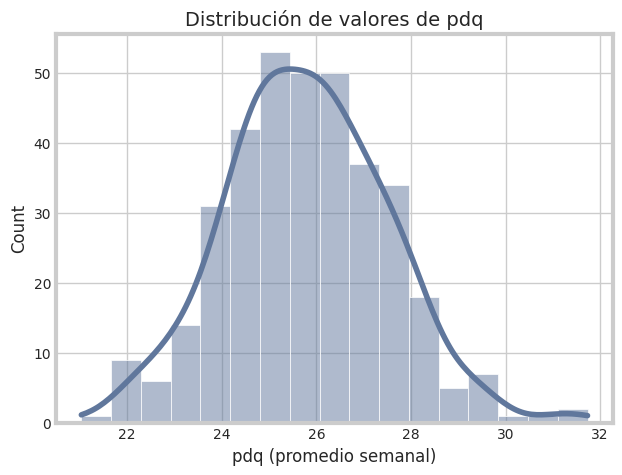

<Axes: ylabel='pdq'>

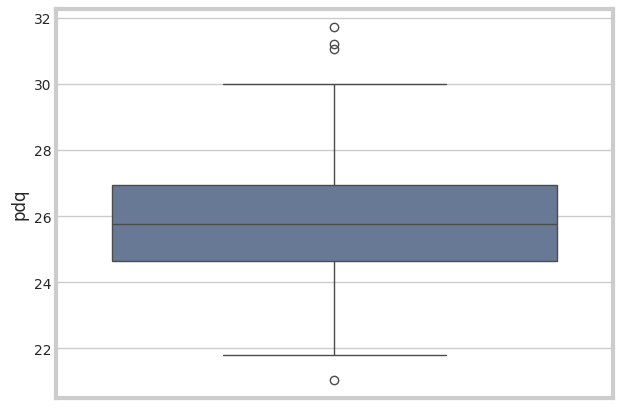

In [10]:
sns.histplot(y['pdq'], kde=True)
plt.title('Distribución de valores de pdq')
plt.xlabel('pdq (promedio semanal)')
plt.show()

sns.boxplot(y=y['pdq'])

tenemos yba distribucion aproximadamente normal con poca asimetria y centrada en torno a 25-26 delitos semanales, con poca asimetria. Además, con el boxplot, tenemos que la mayoría de los valores están entre 23 y 28 delitos semanales, con algunos outliers por sobre 30, es decir, la cantidad de delitos suele oscilar dentro de un rango estrecho, con pocas semanas atípicas que superan notablemente la media.

In [11]:
y['zscore'] = (y['pdq'] - y['pdq'].mean()) / y['pdq'].std()
outliers = y[np.abs(y['zscore']) > 3]
print(outliers)

                  pdq  month  year    zscore
date                                        
2020-12-27  31.077586     12  2020  3.093344
2021-01-03  31.220000      1  2021  3.176690
2021-05-02  31.732759      5  2021  3.476776


Si analizamos los outliers (semanas que superan un umbral(|z| > 3)) tenemos que todos estan entre 2020 y comienzos de 2021 que se pueden asociar quizas por cambios de restricción o condiciones externas de la pandemia.

En conjunto, la serie temporal evidencia que los robos en vehículos en Montreal entre 2015 y 2021 presentan un comportamiento estable pero con una leve tendencia al aumento en los últimos años, acompañado de una variabilidad creciente y cierta estacionalidad

#2. modelamiento con SARIMA


In [29]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        # Ensure y is a Series
        if isinstance(y, pd.DataFrame) and y.shape[1] == 1:
            y = y.iloc[:, 0]
        elif not isinstance(y, pd.Series):
             raise TypeError("Input 'y' must be a pandas Series or a DataFrame with a single column.")


        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        if isinstance(y, pd.DataFrame) and y.shape[1] == 1:
            y = y.iloc[:, 0]
        elif not isinstance(y, pd.Series):
             raise TypeError("Input 'y' must be a pandas Series or a DataFrame with a single column.")


        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test,
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))] #decidi cambiar a 52 ya que esas son las semanas por año, ya que al hacerlo por meses me daba una curva muy plana

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

In [31]:
y_uni = (
    y[['pdq']]
      .copy()
      .asfreq('W')
)

y_uni['pdq'] = pd.to_numeric(y_uni['pdq'], errors='coerce').interpolate()
y_uni['pdq'] = y_uni['pdq'].fillna(method='bfill').fillna(method='ffill')
target_date = pd.Timestamp('2021-01-01')

frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        df_metrics = sarima_model.metrics(y_uni['pdq'], target_date)

        fit = sarima_model.fit_model(y_uni['pdq'], target_date)
        frames.append(df_metrics)
    except Exception as e:
        print(f"FAIL {param}: {e}")
        pass

if frames:
    df_metrics_result = pd.concat(frames, ignore_index=True)
    # Add 'bic' to the sorting criteria if available in df_metrics
    if 'bic' in df_metrics_result.columns:
        df_metrics_result = df_metrics_result.sort_values(
            by=['rmse','mae','mape','bic'], ascending=[True,True,True,True]
        ).reset_index(drop=True)
    else:
         df_metrics_result = df_metrics_result.sort_values(
            by=['rmse','mae','mape'], ascending=[True,True,True]
        ).reset_index(drop=True)

    display(df_metrics_result.head(10))
else:
    print("No models were successfully fitted.")

/tmp/ipython-input-3997538568.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_uni['pdq'] = y_uni['pdq'].fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.4135,3.4062,1.8456,0.0529,0.0527,0.0526,0.0510,0.0525,"SARIMA_(1,0,0)X(1,0,1,52)"
1,1.4409,3.5409,1.8817,0.0539,0.0537,0.0536,0.0519,0.0535,"SARIMA_(0,0,1)X(1,0,1,52)"
2,1.4877,3.6314,1.9056,0.0556,0.0554,0.0553,0.0536,0.0554,"SARIMA_(1,0,1)X(1,1,1,52)"
3,1.4604,3.6919,1.9214,0.0545,0.0543,0.0543,0.0525,0.0543,"SARIMA_(0,0,0)X(1,0,1,52)"
4,1.5065,3.8868,1.9715,0.0573,0.0570,0.0560,0.0552,0.0558,"SARIMA_(1,0,1)X(0,1,1,52)"
5,1.5059,4.0091,2.0023,0.0548,0.0546,0.0560,0.0529,0.0565,"SARIMA_(1,0,0)X(1,1,1,52)"
6,1.5463,4.2003,2.0495,0.0562,0.0560,0.0575,0.0542,0.0579,"SARIMA_(0,0,1)X(1,1,1,52)"
7,1.6597,4.2736,2.0673,0.0638,0.0635,0.0617,0.0614,0.0614,"SARIMA_(1,1,1)X(0,0,1,52)"
8,1.6132,4.2841,2.0698,0.0588,0.0585,0.0600,0.0567,0.0605,"SARIMA_(1,0,0)X(0,1,1,52)"
9,1.6789,4.3596,2.0880,0.0645,0.0642,0.0624,0.0621,0.0621,"SARIMA_(1,1,1)X(1,0,1,52)"


In [32]:
param = [(1,0,0),(1,0,1,52)]
sarima_model=SarimaModels(param)
model_fit=sarima_model.fit_model(y_uni['pdq'],target_date)
best_model=sarima_model.df_testig(y_uni['pdq'],target_date)
best_model.head()

,y,yhat
2021-01-03,31.220000,28.344916
2021-01-10,27.801527,27.068253
2021-01-17,24.200000,26.201146
2021-01-24,24.966667,26.244278
2021-01-31,27.520833,26.315886


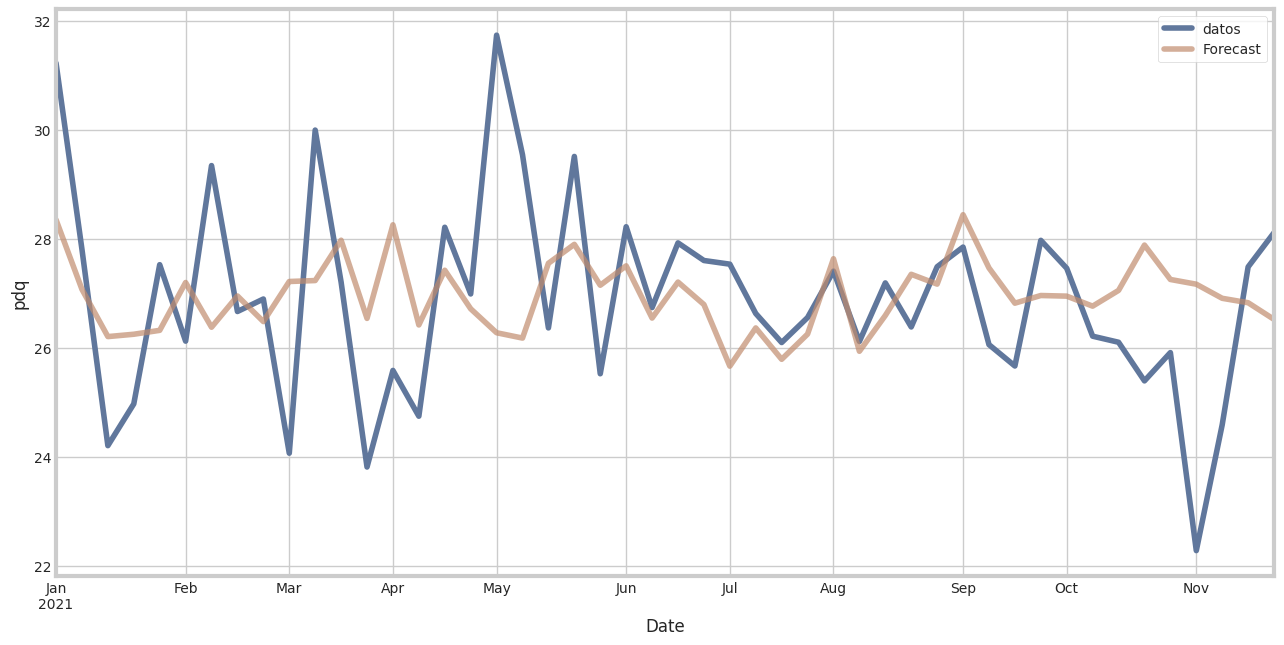

In [33]:
serie = y_uni['pdq']
start_test=best_model.index.min()
end_test=best_model.index.max()

fig, ax = plt.subplots(figsize=(14,7))
serie.loc[start_test:].plot(ax=ax, label='datos')
best_model['yhat'].plot(ax=ax, label='Forecast', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('pdq')
ax.legend()
plt.show()

N° residuos: 313  |  Media: 2.9496  |  Var: 46.0530


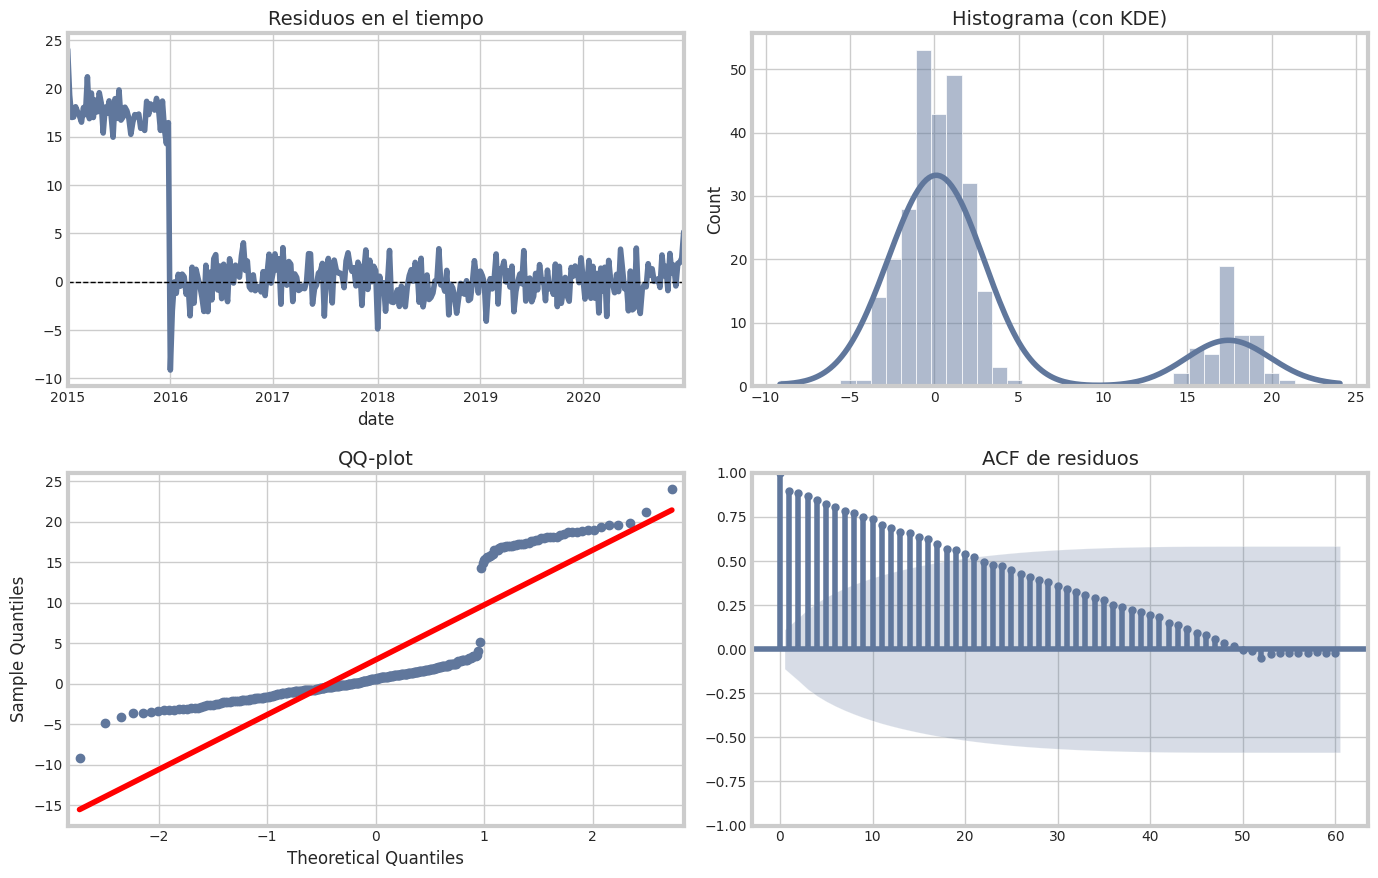

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, normal_ad
from statsmodels.tsa.stattools import adfuller

resid = model_fit.resid.dropna()
S = 52

print(f"N° residuos: {len(resid)}  |  Media: {resid.mean():.4f}  |  Var: {resid.var():.4f}")

fig, axes = plt.subplots(2, 2, figsize=(14,9))

resid.plot(ax=axes[0,0], title="Residuos en el tiempo")
axes[0,0].axhline(0, color='k', lw=1, ls='--')

sns.histplot(resid, kde=True, ax=axes[0,1])
axes[0,1].set_title("Histograma (con KDE)")

qqplot(resid, line='s', ax=axes[1,0])
axes[1,0].set_title("QQ-plot")

plot_acf(resid, lags=min(60, len(resid)-1), ax=axes[1,1])
axes[1,1].set_title("ACF de residuos")
plt.tight_layout()
plt.show()

Los residuos fluctúan alrededor de cero, pero al inicio (2015-2016) hay un salto grande y luego se estabilizan de modo que nos dice que el modelo no logra capturar bien el comportamiento inicial, posiblemente porque la serie tiene un cambio estructural o un nivel distinto en esos primeros períodos.
Después de 2016 la dispersión parece estable (buena señal).

La distribución no es completamente normal: se observa un pico central cerca de 0 pero también un segundo grupo de valores positivos al rededor de  15 y 25, lo cual podria ser por la asimetría o presencia de outliers

en el tercer grafico, podemos ver que hay presencia de outliers ya que Las colas se desvían mucho de la línea roja

mientas que en el cuarto grafico, tenemos que los residuos tienen estructura temporal, es decir, no se comportan como ruido blanco. esto ya que xiste una autocorrelacion significativa en casi todos los rezagos dado que hay mas barritas arriba.

In [35]:
param = [(1,0,0),(1,1,1,52)]
sarima_model=SarimaModels(param)
model_fit=sarima_model.fit_model(y_uni['pdq'],target_date)
best_model=sarima_model.df_testig(y_uni['pdq'],target_date)
best_model.head()

,y,yhat
2021-01-03,31.220000,28.221123
2021-01-10,27.801527,27.015382
2021-01-17,24.200000,25.645781
2021-01-24,24.966667,24.293240
2021-01-31,27.520833,24.840235


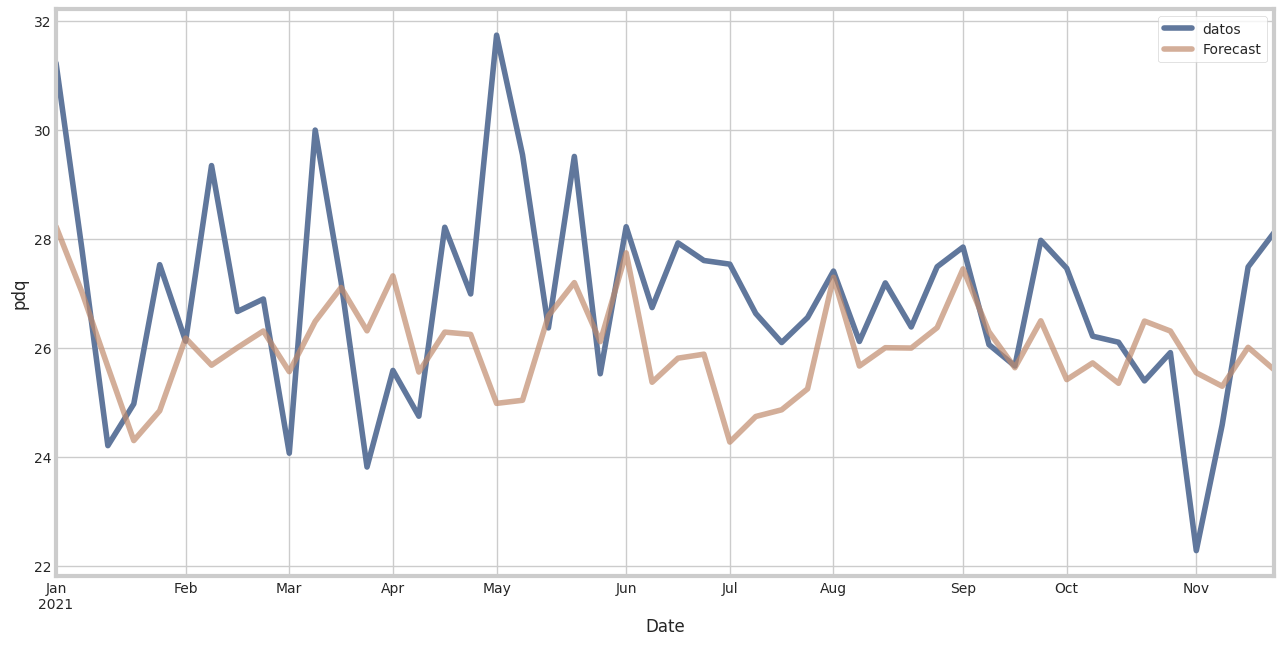

In [36]:
# 1) Serie completa y fecha de inicio del test
serie = y_uni['pdq']
start_test=best_model.index.min()
end_test=best_model.index.max()

fig, ax = plt.subplots(figsize=(14,7))
serie.loc[start_test:].plot(ax=ax, label='datos')
best_model['yhat'].plot(ax=ax, label='Forecast', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('pdq')
ax.legend()
plt.show()

N° residuos: 313   Media: 4.3558  Var: 47.7663


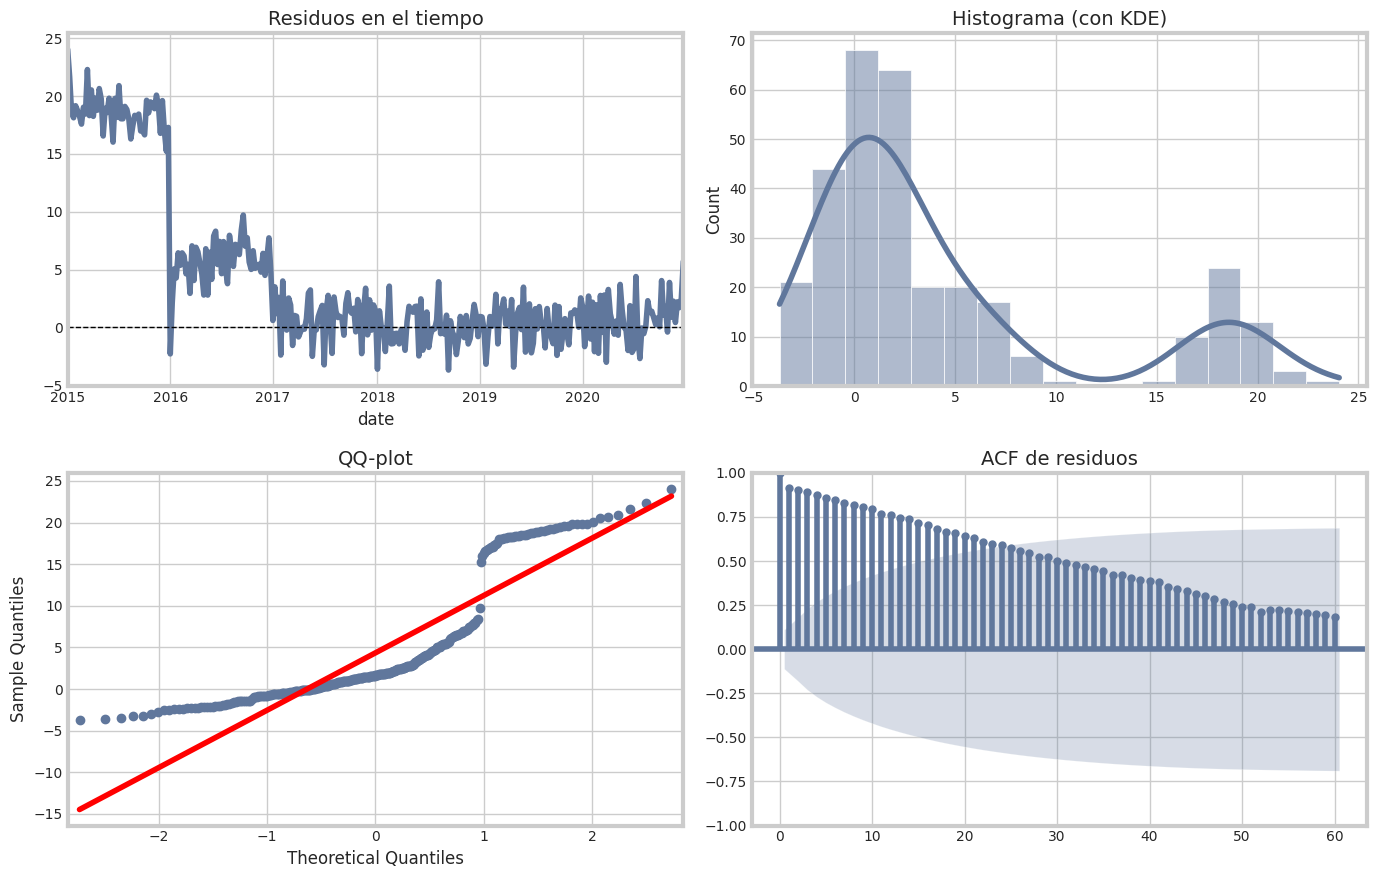

In [38]:
resid = model_fit.resid.dropna()
S = 52

print(f"N° residuos: {len(resid)}   Media: {resid.mean():.4f}  Var: {resid.var():.4f}")

fig, axes = plt.subplots(2, 2, figsize=(14,9))

resid.plot(ax=axes[0,0], title="Residuos en el tiempo")
axes[0,0].axhline(0, color='k', lw=1, ls='--')

sns.histplot(resid, kde=True, ax=axes[0,1])
axes[0,1].set_title("Histograma (con KDE)")

qqplot(resid, line='s', ax=axes[1,0])
axes[1,0].set_title("QQ-plot")

plot_acf(resid, lags=min(60, len(resid)-1), ax=axes[1,1])
axes[1,1].set_title("ACF de residuos")
plt.tight_layout()
plt.show()

Con lo anterior, notemos que el ultimo grafico da un resultado mucho mejor, y podemos concluir que el modelo SARIMA(1,0,0)×(1,1,1,52) es el más adecuado, ya que mejora la independencia de los residuos y se adapta mejor a la estacionalidad anual de la serie.




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [40]:
from prophet import Prophet

y_train_prophet = y_train.reset_index()
y_train_prophet.columns = ["ds","y"]

y_test_prophet = y_test.reset_index()
y_test_prophet.columns = ["ds","y"]

# model
m = Prophet()
m.fit(y_train_prophet)

# forecast
future = m.make_future_dataframe(periods=365*4)
forecast = m.predict(future)[['ds', 'yhat']]
forecast.tail()

result = y_test_prophet.merge(forecast,on = 'ds',how='inner')
regression_metrics(result)

NameError: name 'y_train' is not defined